## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression


##  Load Dataset


In [2]:
# Load California Housing dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='MedianHouseValue')

# Show the first few rows
X.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


## EDA - Basic Info and Correlation

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308     32.540000   -124.350000  
25%        2.429741     33.930000   -1

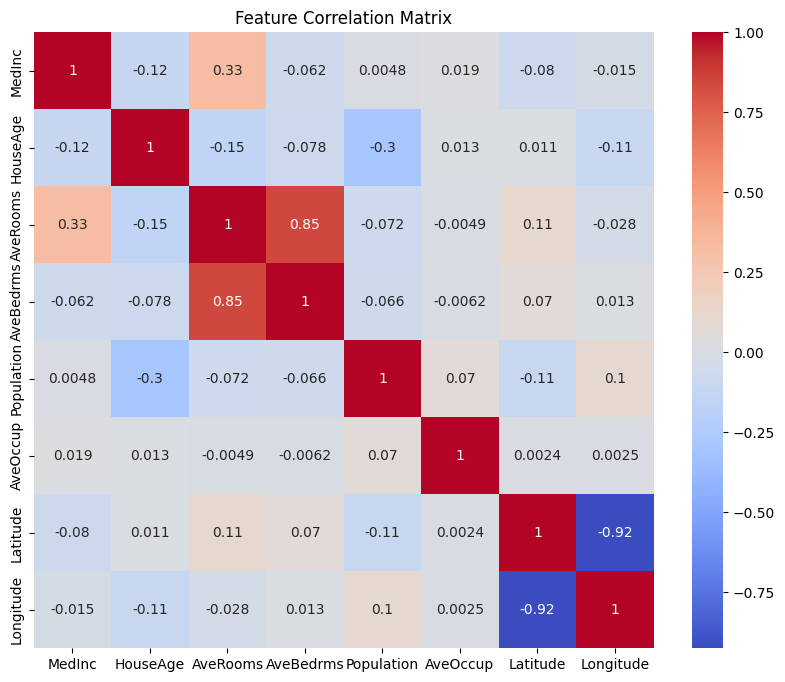

In [3]:
# Summary statistics
print(X.describe())

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


## Feature Selection

In [4]:
# Select top k features using univariate regression tests
selector = SelectKBest(score_func=f_regression, k=6)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features.tolist())

# Reduce X to selected features
X = X[selected_features]


Selected Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Latitude', 'Longitude']


## Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Train Random Forest Regressor

In [6]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

## Evaluate the Model

In [7]:
y_pred = rf.predict(X_test)

print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))


Mean Absolute Error (MAE): 0.33238486412306206
Mean Squared Error (MSE): 0.2589007222973902
Root Mean Squared Error (RMSE): 0.5088228791017462
R² Score: 0.8024275423960083


## Feature Importance Plot

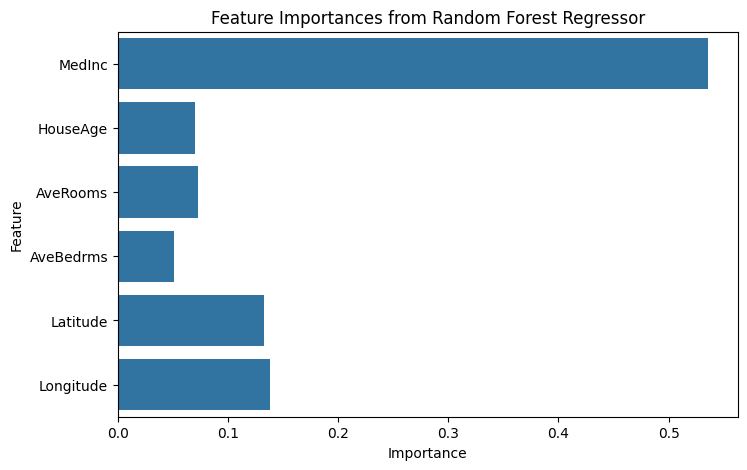

In [8]:
importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances from Random Forest Regressor")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## Hyperparameter Tuning

In [9]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


## Evaluate the Tuned Model

In [10]:
best_model = grid_search.best_estimator_
y_best_pred = best_model.predict(X_test)

print("Tuned Model RMSE:", np.sqrt(mean_squared_error(y_test, y_best_pred)))
print("Tuned Model R² Score:", r2_score(y_test, y_best_pred))


Tuned Model RMSE: 0.50947255770581
Tuned Model R² Score: 0.8019226887442897


## Actual vs. Predicted Plot

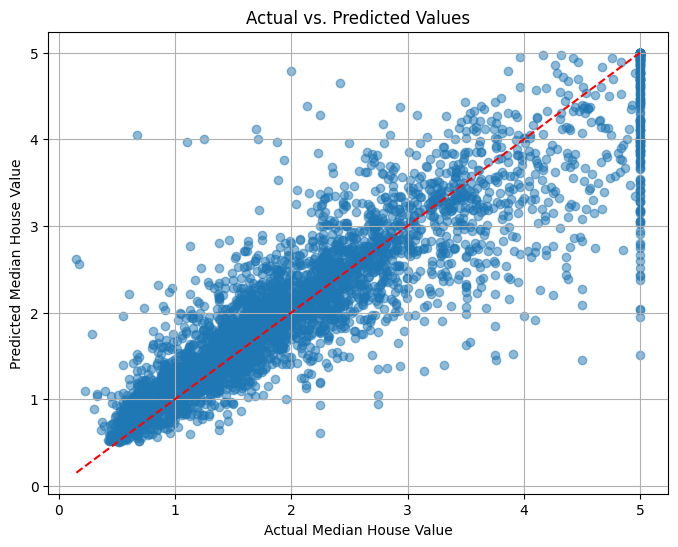

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_best_pred, alpha=0.5)
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("Actual vs. Predicted Values")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.show()
